# Priyanshu - 190651

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Sampling

Part-1<br>
Sampling the source Distribution

In [2]:
def uniformSampler(support = tf.Variable([0.0,1.0]), dims = 2):
  '''
  support is a list which contains info of support of distribution
  dims : dimension of r.v
  '''
  low = []
  high = []
  for i in range(dims):
    low.append(support[0])
    high.append(support[1])

  U = tfd.Uniform(low = low,high = high)
  IndependentUniform = tfd.Independent(U, reinterpreted_batch_ndims=1)

  return IndependentUniform

In [3]:
sampler = uniformSampler([1,2],2)

In [4]:
sampler = uniformSampler()

In [5]:
sampler.sample(1).numpy().squeeze()

array([0.89802146, 0.4663937 ], dtype=float32)

In [6]:
sampler.log_prob([0.5071665 , 1.])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

Part-2<br>
Sampling the target distribution using GMM

In [7]:
def GMMsampler(pi = tf.Variable([0.3,0.7]) ,mus = tf.Variable([[2.,3.],[1.,4.]]),sigmas = tf.Variable([[1.,1.],[1.,2.]])):
  '''
  pi : probabilities of hidden variables
  mus : means of clusters
  sigmas : std of clusters
  '''
  
  gmm = tfd.Mixture(
    cat = tfd.Categorical(probs = pi),
    components = [tfd.MultivariateNormalDiag(loc = mus[i], scale_diag = sigmas[i]) for i in range(mus.shape[0])] )
  
  return gmm

In [8]:
pi = np.array([0.3,0.7]) # probabilities of hidden variables
mus = np.array([[2.,3.],[1.,4.]])
sigmas = np.array([[1.,1.],[1.,2.]])

In [9]:
gmmSampler = GMMsampler()

In [10]:
gmmSampler.sample().numpy()

array([2.5382566, 3.1441536], dtype=float32)

Part-3<br>
Sampling using Normalising Flows(RNVP)<br>
$$x_1 = u_1$$
$$x_2 = u_2.\sigma(u_1) + \mu(u_1)$$

In [11]:
class NN(layers.Layer):

    """
    Neural Network Architecture for calcualting s and t for Real-NVP
    
    :param input_shape: shape of the data coming in the layer
    :param hidden_units: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    :param activation: Activation of the hidden units
    """
    
    def __init__(self, input_shape, n_hidden=[64,64], activation="relu"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for n in n_hidden:
            layer_list.append(layers.Dense(n, activation=activation))
        self.layer_list = layer_list
        self.log_s_layer = layers.Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = layers.Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t

In [12]:
neuralNet = NN(1)

In [13]:
def NFsampler(neuralNet,n):
  '''
  n: number of samples
  neuralNet: neural network to get scaling and shifting factors
  '''
  
  samples = []
  for i in range(n):
    U = ((uniformSampler([0,1], 2)).sample()).numpy()
    u1,u2 = tf.split(U,2)
    u1 = u1[...,np.newaxis]
    u2 = u2[...,np.newaxis]
    x1 = u1
    log_s, t = neuralNet.call(u1)
    x2 = tf.exp(log_s)*U[1] + t
    samples.append([x1,x2])

  samples = np.asarray(samples).squeeze()
  
  return samples 

In [14]:
samples = NFsampler(neuralNet,5)

In [15]:
for sample in samples:
  print(sample)

[0.60340166 0.4768921 ]
[0.88082814 0.85761136]
[0.31378317 0.28726184]
[0.41116846 0.6972295 ]
[0.7236142  0.96755874]


# Planar Flow

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.stats import multivariate_normal
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd=tfp.distributions

In [ ]:
u = tf.cast(np.asarray(uniformSampler(support = [0,1], dims = 2).sample()),tf.float32)
# trainable parameters
c = tf.Variable([np.random.random(),np.random.random()], trainable=True)
b = tf.Variable(np.random.random(), trainable=True)
w = tf.Variable([np.random.random(),np.random.random()], trainable=True)

In [ ]:
def forward(u,w,b,c):
  return tf.cast(u + tf.multiply(c,tf.tanh(tf.tensordot(u,w,1)+b)), tf.float32)
# # checking
# x = forward(u,w,b,c)
# print(x.shape)

In [ ]:
def forwardDetJacobian(u,w,b,c):

  val1 = tf.cast(tf.tensordot(u,w,1)+b,tf.float32)
  val2 = tf.cast(tf.tensordot(c,w,1),tf.float32)
  val3 = tf.cast(tf.square(tf.cosh(val1)),tf.float32)

  return tf.cast(tf.constant(1.0) + tf.divide(val2,val3), tf.float32)
# # checking
# a = forwardDetJacobian(u,w,b,c)
# print(a)

In [ ]:
# Target distribution : GMM
def LogPstar(x):
  p_star = GMMsampler()
  return p_star.log_prob(x)

In [ ]:
# Base Distribution : Multivariate Uniform
def LogP(u):
  p = uniformSampler()
  return p.log_prob(u)

In [ ]:
def loss(w,b,c,n):
  BaseSmapler = uniformSampler()
  Us = BaseSmapler.sample(n)

  Xs = []
  for u in Us:
    Xs.append(forward(u,w,b,c))
  

  logPstar = tf.cast(LogPstar(Xs),tf.float32)

  logDet = []
  for u in Us:
    logDet.append(tf.cast(tf.math.log(forwardDetJacobian(u,w,b,c)),tf.float32))
  
  
  logP = tf.cast(LogP(Us),tf.float32)
  
  return tf.cast(tf.reduce_mean(logP - logDet - logPstar), tf.float32)

# loss(w,b,c,25)

In [ ]:
def step(n = 30, eta = 0.001):
  with tf.GradientTape(persistent=True) as tape:
    lossval = loss(w,b,c,n)

  w_gradient,b_gradient,c_gradient = tape.gradient(lossval, [w,b,c])

  w.assign_sub(w_gradient*eta)
  b.assign_sub(b_gradient*eta)
  c.assign_sub(c_gradient*eta)

In [ ]:
# Training 
n_iter = 10000
for _ in range(n_iter):
    step()

In [ ]:
# initial w = <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.8454408, 0.7108003], dtype=float32)>
print(w)

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.6962957, 1.4396416], dtype=float32)>


In [ ]:
sampler = uniformSampler()
samples = sampler.sample(1000)

In [ ]:
data = []

for i in range(1000):
  data.append(forward(samples[i],w,b,c))


In [ ]:
data = np.asarray(data)

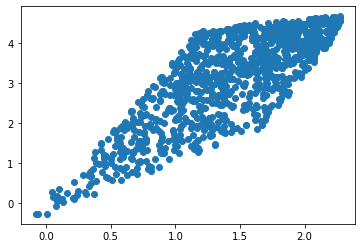

In [ ]:
plt.scatter(data[:,0],data[:,1])

# Radial Flow

Defining Variables

In [17]:
u = tf.cast(np.asarray(uniformSampler(support = [0,1], dims = 2).sample()),tf.float32)

# trainable parameters
u0 = tf.Variable([np.random.random(),np.random.random()], trainable=True)
beta = tf.Variable(np.random.random(), trainable=True)
alpha = tf.Variable(np.random.random(), trainable=True)

In [21]:
def forwardRadial(u,u0,alpha,beta):
  r = tf.norm(u-u0,ord='euclidean')
  val = tf.cast(u + tf.divide(tf.multiply(beta,u-u0),alpha+r), tf.float32)
  return val

#print(forwardRadial(u,u0,alpha,beta))
## prints <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8058238 , 0.58532447], dtype=float32)>

In [23]:
dim = u.shape[0]
print(dim)

2


In [25]:
tf.math.pow(2,3)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [26]:
def forwardDetJacobianRadial(u,u0,alpha,beta):

  D = u.shape[0]
  r = tf.norm(u-u0,ord='euclidean')

  term1 = tf.cast(tf.math.pow((1 + beta/(alpha+r)),D-1), tf.float32)
  term2 = tf.cast(1 + alpha*beta/tf.math.pow(alpha+r,2),tf.float32)

  det = tf.cast(tf.abs(tf.multiply(term1,term2)), tf.float32)


  return det

# print(forwardDetJacobianRadial(u,u0,alpha,beta))
## prints <tf.Tensor: shape=(), dtype=float32, numpy=1.0940843>

In [27]:
forwardDetJacobianRadial(u,u0,alpha,beta)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0940843>

In [29]:
# Base Distribution : Multivariate Uniform
def LogP(u):
  p = uniformSampler()
  return p.log_prob(u)

In [28]:
# Target distribution : GMM
def LogPstar(x):
  p_star = GMMsampler()
  return p_star.log_prob(x)

In [31]:
def lossRadial(u0,alpha,beta,n):
  BaseSmapler = uniformSampler()
  Us = BaseSmapler.sample(n)

  Xs = []
  for u in Us:
    Xs.append(forwardRadial(u,u0,alpha,beta))
  

  logPstar = tf.cast(LogPstar(Xs),tf.float32)

  logDet = []
  for u in Us:
    logDet.append(tf.cast(tf.math.log(forwardDetJacobianRadial(u,u0,alpha,beta)),tf.float32))
  
  
  logP = tf.cast(LogP(Us),tf.float32)
  
  return tf.cast(tf.reduce_mean(logP - logDet - logPstar), tf.float32)

## check
# print(lossRadial(u0,alpha,beta,25))
# prints <tf.Tensor: shape=(), dtype=float32, numpy=4.415584>

<tf.Tensor: shape=(), dtype=float32, numpy=4.415584>

In [32]:
def step(n = 30, eta = 0.001):
  with tf.GradientTape(persistent=True) as tape:
    lossval = lossRadial(u0,alpha,beta,n)

  u0_gradient,alpha_gradient,beta_gradient = tape.gradient(lossval, [u0,alpha,beta])

  u0.assign_sub(u0_gradient*eta)
  alpha.assign_sub(alpha_gradient*eta)
  beta.assign_sub(beta_gradient*eta)

In [34]:
# Training 
n_iter = 10000
for _ in range(n_iter):
    step()

In [35]:
sampler = uniformSampler()
samples = sampler.sample(1000)

In [40]:
data = []

for i in range(1000):
  data.append(forwardRadial(samples[i],u0,alpha,beta))

In [42]:
data = np.asarray(data)

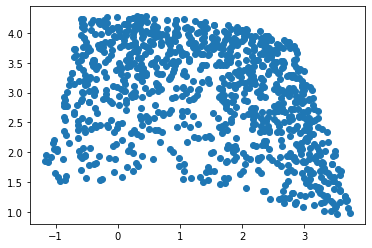

In [43]:
plt.scatter(data[:,0],data[:,1])